# Adversarial Discriminative Domain Adaptation (ADDA) in FastEstimator

In this notebook we will demonstrate how to perform domain adaptation in FastEstimator.
Specifically, we will demonstrate one of adversarial training based domain adaptation methods, [*Adversarial Discriminative Domain Adaptation (ADDA)*](https://arxiv.org/abs/1702.05464). 

We will look at how to adapt a digit classifier trained on MNIST dataset to another digit dataset, USPS dataset.
The digit classifer is composed of a feature extractor network and a classifier.

In [1]:
import os
import time

import tensorflow as tf
import numpy as np

import fastestimator as fe

## Input Data Pipeline
We will first download the two datasets using our dataset api.

In [2]:
from fastestimator.dataset import mnist, usps
from fastestimator.op.numpyop import ImageReader
from fastestimator import RecordWriter
usps_train_csv, usps_eval_csv, usps_parent_dir = usps.load_data()
mnist_train_csv, mnist_eval_csv, mnist_parent_dir = mnist.load_data()

Extracting /home/ubuntu/fastestimator_data/USPS/zip.train.gz
Extracting /home/ubuntu/fastestimator_data/USPS/zip.test.gz


In [ ]:
# parameters
batch_size = 128
epochs = 100

The dataset api creates a train csv file with each row containing a relative path to a image and the class label.
Two train csv files will have the same column names.
We need to change these column names to unique name for our purpose.

In [3]:
import pandas as pd
df = pd.read_csv(mnist_train_csv)
df.columns = ['source_img', 'source_label']
df.to_csv(mnist_train_csv, index=False)

df = pd.read_csv(usps_train_csv)
df.columns = ['target_img', 'target_label']
df.to_csv(usps_train_csv, index=False)

With the modified csv files, we can now create an input data pipeline that returns a batch from the MNIST dataset and the USPS dataset. 
#### Note that the input data pipeline created here is an unpaired dataset of the MNIST and the USPS.

In [4]:
from fastestimator.op.tensorop import Resize, Minmax

writer = RecordWriter(save_dir=os.path.join(os.path.dirname(mnist_parent_dir), 'adda', 'tfr'),
                      train_data=(usps_train_csv, mnist_train_csv),
                      ops=(
                          [ImageReader(inputs="target_img", outputs="target_img", parent_path=usps_parent_dir, grey_scale=True)], # first tuple element
                          [ImageReader(inputs="source_img", outputs="source_img", parent_path=mnist_parent_dir, grey_scale=True)])) # second tuple element


We apply the following preprocessing to both datasets:
* Resize of images to $32\times32$
* Minmax pixel value normalization

In [5]:
pipeline = fe.Pipeline(
    batch_size=batch_size,
    data=writer,
    ops=[
        Resize(inputs="target_img", outputs="target_img", size=(32, 32)),
        Resize(inputs="source_img", outputs="source_img", size=(32, 32)),
        Minmax(inputs="target_img", outputs="target_img"),
        Minmax(inputs="source_img", outputs="source_img")
    ]
)
a = pipeline.show_results()

FastEstimator: Reading non-empty directory: /home/ubuntu/fastestimator_data/adda/tfr
FastEstimator: Found 60000 examples for train in /home/ubuntu/fastestimator_data/adda/tfr/train_summary1.json
FastEstimator: Found 7291 examples for train in /home/ubuntu/fastestimator_data/adda/tfr/train_summary0.json


We can visualize an example output from the pipeline.

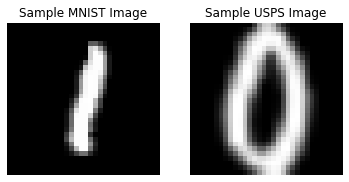

In [6]:
import matplotlib
from matplotlib import pyplot as plt

plt.subplot(121)
plt.imshow(np.squeeze(a[0]["source_img"][1]), cmap='gray');
plt.axis('off');
plt.title('Sample MNIST Image');

plt.subplot(122)
plt.imshow(np.squeeze(a[0]["target_img"][3]), cmap='gray');
plt.axis('off');
plt.title('Sample USPS Image');

## Network Definition

With ``Pipeline`` defined, we define the network architecture.
As we dicussed previously, the classification model is composed of the feature extraction network and the classifier network.
The training scheme is very similar to that of GAN; the objective is to train a feature extractor network for the USPS dataset so that the discriminator cannot reliably distinguish MNIST examples and USPS examples.
The feature extractor network for the USPS dataset is initialized from the feature extractor network for the MNIST dataset.

In [7]:
from tensorflow.keras import layers, Model, Sequential

model_path = os.path.join(os.getcwd(), "feature_extractor.h5")

def build_feature_extractor(input_shape=(32, 32, 1), feature_dim=512):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(feature_dim, activation='relu'))        
    return model

def build_classifer(feature_dim=512, num_classes=10):
    model = Sequential()
    model.add(layers.Dense(num_classes, activation='softmax', input_dim=feature_dim))
    return model

def build_discriminator(feature_dim=512):
    model = Sequential()
    model.add(layers.Dense(1024, activation='relu', input_dim=feature_dim))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Step2: Define Network
feature_extractor = fe.build(model_def=build_feature_extractor,
                             model_name="fe",
                             loss_name="fe_loss",
                             optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9))

discriminator = fe.build(model_def=build_discriminator,
                         model_name="disc",
                         loss_name="d_loss",
                         optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9))

We need to define a ``TensorOp`` to extract a feature from MNIST images.
This feature will be used as an input to the discriminator.

In [8]:
from fastestimator.op import TensorOp
from fastestimator.op.tensorop import Loss, ModelOp

class ExtractSourceFeature(TensorOp):
    def __init__(self, model_path, inputs, outputs=None, mode=None):
        super().__init__(inputs, outputs, mode)
        self.source_feature_extractor = tf.keras.models.load_model(model_path, compile=False)
        self.source_feature_extractor.trainable = False

    def forward(self, data, state):        
        return self.source_feature_extractor(data)

We define loss functions for the feature extractor network and the discriminator network.

In [9]:
class FELoss(Loss):
    def __init__(self, inputs, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        
    def forward(self, data, state):
        target_score = data        
        return self.cross_entropy(tf.ones_like(target_score), target_score)

class DLoss(Loss):
    def __init__(self, inputs, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        
    def forward(self, data, state):
        source_score, target_score = data
        source_loss = self.cross_entropy(tf.ones_like(source_score), source_score)
        target_loss = self.cross_entropy(tf.zeros_like(target_score), target_score)
        total_loss = source_loss + target_loss
        return 0.5 * total_loss

We define the forward pass of the networks within one iteration of the training.

In [10]:
network = fe.Network(ops=[
    ModelOp(inputs="target_img", outputs="target_feature", model=feature_extractor),
    ModelOp(inputs="target_feature", outputs="target_score", model=discriminator),
    ExtractSourceFeature(model_path=model_path, inputs="source_img", outputs="source_feature"),
    ModelOp(inputs="source_feature", outputs="source_score", model=discriminator),
    DLoss(inputs=("source_score", "target_score"), outputs="d_loss"),
    FELoss(inputs="target_score", outputs="fe_loss")
])

We need to define two ``Trace``:
* ``LoadPretrainedFE`` to load the weights of the feature extractor trained on MNIST
* ``EvaluateTargetClassifier`` to evaluate the classifier on the USPS dataset.

There are three key thins to keep in mind:
* The classifier network is never updated with any target label information
* Only the feature extractor is fine tuned to confuse the discriminator network
* The classifier only classifies on the basis of the output of the feature extractor network

In [11]:
from fastestimator.trace import Trace

class LoadPretrainedFE(Trace):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        
    def on_begin(self, state):
        self.network.model[self.model_name].load_weights('feature_extractor.h5')
        print("FastEstimator-LoadPretrainedFE: loaded pretrained feature extractor")

class EvaluateTargetClassifier(Trace):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.target_model = tf.keras.Sequential()
        self.acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        
    def on_begin(self, state):
        self.target_model.add(self.network.model[self.model_name])
        self.target_model.add(
            tf.keras.models.load_model("classifier.h5")
        )
    def on_batch_end(self, state):
        if state["epoch"] == 0 or state["epoch"] == 99:
            target_img, target_label = state["batch"]["target_img"], state["batch"]["target_label"]
            logits = self.target_model(target_img)
            self.acc_metric(target_label, logits)
    
    def on_epoch_end(self, state):
        if state["epoch"] == 0 or state["epoch"] == 99:
            acc = self.acc_metric.result()
            print("FastEstimator-EvaluateTargetClassifier: %0.4f at epoch %d" % (acc, state["epoch"]))
            self.acc_metric.reset_states()

## Defining Estimator

With ``Pipeline``, ``Network``, and ``Trace`` defined, we now define ``Estimator`` to put everything together

In [12]:
traces = [LoadPretrainedFE(model_name="fe"),
          EvaluateTargetClassifier(model_name="fe")]
estimator = fe.Estimator(
    pipeline= pipeline, 
    network=network,
    traces = traces,
    epochs = epochs
)

We call ``fit`` method to start the training.

In [13]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator: Reading non-empty directory: /home/ubuntu/fastestimator_data/adda/tfr
FastEstimator: Found 60000 examples for train in /home/ubuntu/fastestimator_data/adda/tfr/train_summary1.json
FastEstimator: Found 7291 examples for train in /home/ubuntu/fastestimator_data/adda/tfr/train_summary0.json
FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
FastEstimator-LoadPretrainedFE: loaded pretrained feature extractor
FastEstimator-Start: step: 0; total_train_steps: 1400; fe_lr: 1e-04; disc_lr: 1e-04; 
INFO:tensorflow:batch_all_r

``EvaluateTargetClassifier`` outputs the classification accuracy on the USPS at the beginning of the training and the end of the training. We can observe significant improvement in the performance.